In [1]:
import itertools
import operator
import re
from abc import *
from copy import deepcopy
from operator import itemgetter
from typing import *

from networkx.algorithms.approximation import large_clique_size

from nodestimation.learning.connectoming import *
from nodestimation.learning.modification import normalize_df
import numpy as np
import scipy as sp
import networkx as nx
import mne
import time
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors._dist_metrics import DistanceMetric
from sklearn.utils import shuffle
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.estimation import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.learning.informativeness import CrossInformativeness, Informativeness, SubjectsInformativeness, \
    NodesInformativeness
from nodestimation.learning.networking import sparse_graph, graph_to_hemispheres, hemispheres_division_modularity, \
    metric_for_hemispheres
from nodestimation.processing.features import prepare_features
from nodestimation.project import find_subject_dir, conditions_unique_code
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nibabel
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.modification import append_series, promote
import nodestimation.learning.modification as lmd
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import matplotlib as mpl
from nodestimation.learning.selection import SubjectsStatistic, Wilcoxon, Mannwhitneyu, Test
from scipy.stats import wilcoxon
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy.fftpack import fftfreq, irfft, rfft
from scipy.fftpack import fftfreq, irfft, rfft

/home/user/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [ ]:
SUBJECTS = pipeline(
    methods=['wpli', 'envelope', 'coh', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli2_debiased'],
    freq_bands=(4, 8),
    centrality_metrics=['eigen', 'between', 'degree', 'info']
    )

ENGEL1 = [
    'B1C2',
    'B1R1',
    'G1R1',
    'G1V2',
    'J1T2',
    'K1V1',
    'L1P1',
    'M1G2',
    'M1N2',
    'O1O2',
    'R1D2',
    'S1A2',
    'S1B1',
    'S1H1',
    'S1U3'
]
ENGEL2 = [
    'L2M1',
    'M2S2',
    'N2K2',
    'P1H2'
]
ENGEL34 = [
    'N3S2',
    'S3R1',
    'K4L2'
]
REJECTED = [
    'S1U3',
    'P1H2'
]

INCLUDED = [
    'B1R1',
    'G1R1',
    'G1V2',
    'L1P1',
    'M1G2',
    'M1N2',
    'O1O2',
    'R1D2',
]

# subjects = SUBJECTS.copy()
subjects = [
        subject
        for subject in SUBJECTS
        if subject.name not in REJECTED
           # and subject.name not in ENGEL34
    ]

STAT = SubjectsStatistic(
    subjects,
    'resected',
    centrality_metric='eigen'
)

In [ ]:
GRAPHS = [
    metric_for_hemispheres(subjects, nx.algorithms.cluster.transitivity),
    metric_for_hemispheres(subjects, nx.algorithms.smetric.s_metric, normalized=False),
    metric_for_hemispheres(subjects, nx.algorithms.global_efficiency),
    # additional metrics
    # metric: accuracy | specificity | sensitivity with Engel 1&2 groups
    # metric_for_hemispheres(subjects, nx.algorithms.cluster.average_clustering, weight='weight'), # 51 | 52 | 57
    # metric_for_hemispheres(subjects, large_clique_size), # 62 | 68 | 60
]

In [ ]:
# 75% of engel 1 and 2 -> train set, 25% engel 1 and 2 -> test set, the rest -> test set

acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
for dataset, name in zip(GRAPHS, ['transitivity', 's_metric', 'global_efficiency']):
# for dataset, name in zip(GRAPHS, ['average_clustering']):
    for _ in range(1000):

        y = dataset['resected'].to_numpy()
        index = dataset.index
        x = dataset[[
            f'{name}_for_wpli_4-8Hz',
            f'{name}_for_envelope_4-8Hz'
        ]].to_numpy()
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        x_train, y_train = list(), list()
        x_test, y_test = list(), list()
        for i, sample, sample_name in zip(index, x, y):
            if any([subject in i for subject in ENGEL1]):
                    x_train.append(sample)
                    y_train.append(sample_name)
            else:
                x_test.append(sample)
                y_test.append(sample_name)

        x_train, x_test1, y_train, y_test1 = train_test_split(x_train, y_train, train_size=0.5)

        x_train = np.array(x_train)
        x_test = np.array([*x_test, *x_test1])
        y_test = np.array([*y_test, *y_test1])

        # x_train, x_test, y_train, y_test = train_test_split(x, y)

        # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
        # clf = AdaBoostClassifier(n_estimators=10)
        # clf = svm.SVC(kernel='sigmoid')
        clf = svm.SVC()
        # clf = svm.SVC(kernel='linear')
        # clf = svm.SVC(kernel='poly')
        # clf = SGDClassifier()
        # clf = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')
        # clf = LogisticRegression(class_weight={True: 1, False: .8})
        # clf = LogisticRegression()
        # clf = RandomForestClassifier(max_depth=20)
        # clf = GaussianNB()
        # clf = LinearDiscriminantAnalysis()
        # clf = QuadraticDiscriminantAnalysis()
        # clf = KMeans(n_clusters=2, algorithm='full')
        # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)

        clf.fit(x_train, y_train)
        pred = clf.predict(x_test)

        acc.append(accuracy_score(y_test, pred))
        tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
        if not any([tn + fp == 0, tp + fn == 0, tn + fn == 0, tp + fp == 0]):
            spec.append(tn / (tn + fp))
            sens.append(tp / (tp + fn))
            negpred.append(tn/(tn + fn))
            pospred.append(tp/(tp + fp))
    spec = [s for s in spec if not np.isnan(s)]
    sens = [s for s in sens if not np.isnan(s)]
    print(name)
    print('acc: ', np.array(acc).mean())
    print('spec: ', np.array(spec).mean())
    print('sens: ', np.array(sens).mean())

In [ ]:
import pickle

# features = ['4-8Hz_wpli', '4-8Hz_envelope']

# features = ['4-8Hz_plv', '4-8Hz_envelope']
#
#
# true_data = stat.datasets['true'][features]
# false_data = stat.datasets['false_mirror'][features]
#
# engel_1_true = true_data.loc[(elem[:4] in ENGEL1 for elem in true_data.index)]
# engel_1_false = false_data.loc[(elem[:4] in ENGEL1 for elem in false_data.index)]
#
# engel_2_3_4_true = true_data.loc[(elem[:4] not in ENGEL1 for elem in true_data.index)]
# engel_2_3_4_false = false_data.loc[(elem[:4] not in ENGEL1 for elem in false_data.index)]
#
# engel_1_2_true = true_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] for elem in true_data.index)]
# engel_1_2_false = false_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] for elem in false_data.index)]
#
# engel_3_4_true = true_data.loc[(elem[:4] not in [*ENGEL1, *ENGEL2] for elem in true_data.index)]
# engel_3_4_false = false_data.loc[(elem[:4] not in [*ENGEL1, *ENGEL2] for elem in false_data.index)]
#
# engel_1 = pd.concat([engel_1_true, engel_1_false], axis=0)
#
# d1, d2 = np.array_split(engel_1.sample(frac=1), 2)
#
# d1

path = f'/home/user//Documents/initial_stats.pkl'
stats = pickle.load(open(path, 'rb'))

In [ ]:
eigen_stat = stats[0]
perloc_stat = stats[-1]

full_true_data_eigen = eigen_stat.datasets['true']['4-8Hz_wpli']
full_true_data_perloc = perloc_stat.datasets['true']['4-8Hz_envelope']
full_false_data_eigen = eigen_stat.datasets['false_mirror']['4-8Hz_wpli']
full_false_data_perloc = perloc_stat.datasets['false_mirror']['4-8Hz_envelope']

full_true_data = pd.concat([full_true_data_eigen, full_true_data_perloc], axis=1)

full_false_data = pd.concat([full_false_data_eigen, full_false_data_perloc], axis=1)


features = ['4-8Hz_envelope', '4-8Hz_wpli']

acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

stat = deepcopy(STAT)

for i in range(1000):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10)
    clf = svm.SVC(kernel='sigmoid')
    # clf = svm.SVC()
    # clf = svm.SVC(kernel='linear')
    # clf = svm.SVC(kernel='poly')
    # clf = SGDClassifier()
    # clf = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')
    # clf = LogisticRegression(class_weight={True: 1, False: .8})
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = QuadraticDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)

    scaler = StandardScaler()

    # full_true_data = stat.datasets['true'][features]
    # full_false_data = stat.datasets['false_mirror'][features]

    ## All data
    # true_data = full_true_data.assign(resected=True)
    # false_data = full_false_data.assign(resected=False)

    ## Engel1 only
    # engel_1_true = full_true_data.loc[(elem[:4] in ENGEL1 for elem in full_true_data.index)]
    # engel_1_false = full_false_data.loc[(elem[:4] in ENGEL1 for elem in full_false_data.index)]
    # true_data = engel_1_true.assign(resected=True)
    # false_data = engel_1_false.assign(resected=False)

    ## Engel1&2 data
    engel_1_2_true = full_true_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_true_data.index)]
    engel_1_2_false = full_false_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_false_data.index)]
    true_data = engel_1_2_true.assign(resected=True)
    false_data = engel_1_2_false.assign(resected=False)

    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)

    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)
    x = scaler.fit_transform(dataset)
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    ## Engel1 - train, the rest - test
    # engel_1_true = full_true_data.loc[(elem[:4] in ENGEL1 and not elem[:4] in REJECTED for elem in full_true_data.index)].assign(resected=True)
    # engel_1_false = full_false_data.loc[(elem[:4] in ENGEL1 and not elem[:4] in REJECTED for elem in full_false_data.index)].assign(resected=False)
    # engel_2_3_4_true = full_true_data\
    #     .loc[(elem[:4] not in ENGEL1 and not elem[:4] in REJECTED for elem in full_true_data.index)].assign(resected=True)
    # engel_2_3_4_false = full_false_data\
    #     .loc[(elem[:4] not in ENGEL1 and not elem[:4] in REJECTED for elem in full_false_data.index)].assign(resected=False)
    # engel_1 = pd.concat([engel_1_true, engel_1_false], axis=0)
    # engel_1_train, engel_1_test = np.array_split(engel_1.sample(frac=1), 2)
    # engel_2_3_4 = pd.concat([engel_2_3_4_true, engel_2_3_4_false], axis=0)
    #
    # y_train = engel_1_train['resected'].to_numpy()
    # x_train = scaler.fit_transform(engel_1_train.drop(['resected'], axis=1))
    #
    # engel_test = pd.concat([engel_2_3_4, engel_1_test], axis=0).sample(frac=1)
    #
    # y_test = engel_test['resected'].to_numpy()
    # x_test = scaler.fit_transform(engel_test.drop(['resected'], axis=1))


    # # Engel1&2 - train, the rest - test
    # engel_1_2_true = full_true_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_true_data.index)].assign(resected=True)
    # engel_1_2_false = full_false_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_false_data.index)].assign(resected=False)
    # engel_3_4_true = full_true_data\
    #     .loc[(elem[:4] not in [*ENGEL1, *ENGEL2, *REJECTED] for elem in full_true_data.index)].assign(resected=True)
    # engel_3_4_false = full_false_data\
    #     .loc[(elem[:4] not in [*ENGEL1, *ENGEL2, *REJECTED] for elem in full_false_data.index)].assign(resected=False)
    # engel_1_2 = pd.concat([engel_1_2_true, engel_1_2_false], axis=0)
    # engel_1_2_train, engel_1_2_test = np.array_split(engel_1_2.sample(frac=1), 2)
    # engel_3_4 = pd.concat([engel_3_4_true, engel_3_4_false], axis=0)
    #
    # y_train = engel_1_2_train['resected'].to_numpy()
    # x_train = scaler.fit_transform(engel_1_2_train.drop(['resected'], axis=1))
    #
    # engel_test = pd.concat([engel_3_4, engel_1_2_test], axis=0).sample(frac=1)
    #
    # y_test = engel_test['resected'].to_numpy()
    # x_test = scaler.fit_transform(engel_test.drop(['resected'], axis=1))

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)

    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
    if not any([tn + fp == 0, tp + fn == 0, tn + fn == 0, tp + fp == 0]):
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))
        negpred.append(tn/(tn + fn))
        pospred.append(tp/(tp + fp))

print('acc: ', np.array(acc).mean())
print('spec: ', np.array(spec).mean())
print('sens: ', np.array(sens).mean())

In [ ]:
print(stats[-2])


In [ ]:
## check all possible combinations of features (nodes)


index = [stat.centrality_metric for stat in stats]

for feat in ['wpli', 'coh', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli2_debiased']:
    series = list()
    for stat1 in stats:
        curr_series = list()
        for stat2 in stats:
            full_true_data_1 = stat1.datasets['true'][f'4-8Hz_{feat}']
            full_true_data_2 = stat2.datasets['true']['4-8Hz_envelope']
            full_false_data_1 = stat1.datasets['false_mirror'][f'4-8Hz_{feat}']
            full_false_data_2 = stat2.datasets['false_mirror']['4-8Hz_envelope']

            full_true_data = pd.concat([full_true_data_1, full_true_data_2], axis=1)

            full_false_data = pd.concat([full_false_data_1, full_false_data_2], axis=1)


            features = ['4-8Hz_envelope', f'4-8Hz_{feat}']

            acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

            for i in range(1000):
                clf = svm.SVC(kernel='sigmoid')

                scaler = StandardScaler()

                ## Engel1&2 data
                engel_1_2_true = full_true_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_true_data.index)]
                engel_1_2_false = full_false_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_false_data.index)]
                true_data = engel_1_2_true.assign(resected=True)
                false_data = engel_1_2_false.assign(resected=False)

                dataset = pd.concat([true_data, false_data], axis=0)
                dataset = dataset.sample(frac = 1)

                y = dataset['resected'].to_numpy()
                dataset = dataset.drop(['resected'], axis=1)
                x = scaler.fit_transform(dataset)
                x_train, x_test, y_train, y_test = train_test_split(x, y)

                clf.fit(x_train, y_train)
                pred = clf.predict(x_test)

                acc.append(accuracy_score(y_test, pred))
                tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
                if not any([tn + fp == 0, tp + fn == 0, tn + fn == 0, tp + fp == 0]):
                    spec.append(tn / (tn + fp))
                    sens.append(tp / (tp + fn))
                    negpred.append(tn/(tn + fn))
                    pospred.append(tp/(tp + fp))

            curr_series.append(np.array(acc).mean())
            # print(f'{stat1.centrality_metric} for {features[1]},\n{stat2.centrality_metric} for {features[0]}')
            # print('acc: ', np.array(acc).mean())
            # print('spec: ', np.array(spec).mean())
            # print('sens: ', np.array(sens).mean())
        series.append(pd.Series(curr_series))

    df = pd.DataFrame(series, index=index).rename(columns={i: col for i, col in enumerate(index)})
    df.to_csv(f'/home/user/Documents/metrics_accuracy_{feat}.csv')
    print(f'{features[1]}|{features[0]}')
    print(df)

In [276]:
subjects = [subject for subject in SUBJECTS if subject.name in [*ENGEL1, *ENGEL2]]
GRAPHS = [
    metric_for_hemispheres(subjects, nx.algorithms.cluster.transitivity),
    metric_for_hemispheres(subjects, nx.algorithms.smetric.s_metric, normalized=False),
    metric_for_hemispheres(subjects, nx.algorithms.global_efficiency),
    metric_for_hemispheres(subjects, nx.algorithms.cluster.average_clustering, weight='weight'),

]

In [274]:
# print(GRAPHS[-1])

In [277]:
## check all possible combinations of features (hemispheres)
index = ['transitivity', 's_metric', 'global_efficiency', 'average_clustering']
features = ['wpli', 'coh', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli2_debiased']


for feat in [features[0]]:
    series = list()
    for graph1, kind1 in zip(GRAPHS, index):
        curr_series = list()
        for graph2, kind2 in zip(GRAPHS, index):
            assert all(graph1['resected'] == graph2['resected'])
            full_data_1 = graph1[[f'{kind1}_for_{feat}_4-8Hz', 'resected']]
            full_data_2 = graph2[[f'{kind2}_for_envelope_4-8Hz']]
            full_data = pd.concat([full_data_1, full_data_2], axis=1)
            features = [f'{kind2}_for_envelope_4-8Hz', f'{kind1}_for_{feat}_4-8Hz']

            acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

            for i in range(1000):
                clf = svm.SVC(kernel='sigmoid')

                scaler = StandardScaler()

                ## Engel1&2 data
                engel_1_2 = full_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_data.index)]

                dataset = engel_1_2.sample(frac = 1)
                y = dataset['resected'].to_numpy()
                dataset = dataset.drop(['resected'], axis=1)
                x = scaler.fit_transform(dataset)
                x_train, x_test, y_train, y_test = train_test_split(x, y)

                clf.fit(x_train, y_train)
                pred = clf.predict(x_test)

                acc.append(accuracy_score(y_test, pred))
                tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
                if not any([tn + fp == 0, tp + fn == 0, tn + fn == 0, tp + fp == 0]):
                    spec.append(tn / (tn + fp))
                    sens.append(tp / (tp + fn))
                    negpred.append(tn/(tn + fn))
                    pospred.append(tp/(tp + fp))

            curr_series.append(np.array(acc).mean())
            print(f'{features[1]},\n{features[0]}')
            print('acc: ', np.array(acc).mean())
            print('spec: ', np.array(spec).mean())
            print('sens: ', np.array(sens).mean())
        series.append(pd.Series(curr_series))

    df = pd.DataFrame(series, index=index).rename(columns={i: col for i, col in enumerate(index)})
    df.to_csv(f'/home/user/Documents/hemispheres_metrics_accuracy_{feat}.csv')
    print(f'{features[1]}|{features[0]}')
    print(df)

transitivity_for_wpli_4-8Hz,
transitivity_for_envelope_4-8Hz
acc:  0.7334444444444445
spec:  0.7852042518709186
sens:  0.7120656370656371
transitivity_for_wpli_4-8Hz,
s_metric_for_envelope_4-8Hz
acc:  0.7592222222222221
spec:  0.7815601566604576
sens:  0.7581470602283039
transitivity_for_wpli_4-8Hz,
global_efficiency_for_envelope_4-8Hz
acc:  0.759
spec:  0.7878187711521045
sens:  0.7568854568854568
transitivity_for_wpli_4-8Hz,
average_clustering_for_envelope_4-8Hz
acc:  0.6862222222222223
spec:  0.7661181373958033
sens:  0.6344327871993868
s_metric_for_wpli_4-8Hz,
transitivity_for_envelope_4-8Hz
acc:  0.7348888888888889
spec:  0.806215601818617
sens:  0.6897858339315627
s_metric_for_wpli_4-8Hz,
s_metric_for_envelope_4-8Hz
acc:  0.7515555555555556
spec:  0.7938028370826766
sens:  0.728167836843865
s_metric_for_wpli_4-8Hz,
global_efficiency_for_envelope_4-8Hz
acc:  0.7507777777777779
spec:  0.7902660362038497
sens:  0.7411806849118784
s_metric_for_wpli_4-8Hz,
average_clustering_for_envel

In [ ]:
# wpli + transitivity & envelope + global efficiency

subjects = [subject for subject in SUBJECTS if subject.name not in REJECTED]
GRAPHS = [
    metric_for_hemispheres(subjects, nx.algorithms.cluster.transitivity),
    # metric_for_hemispheres(subjects, nx.algorithms.smetric.s_metric, normalized=False),
    metric_for_hemispheres(subjects, nx.algorithms.global_efficiency),
]

In [ ]:
wpli = GRAPHS[0]['transitivity_for_wpli_4-8Hz']
envelope = GRAPHS[1]['global_efficiency_for_envelope_4-8Hz']
assert all(GRAPHS[0]['resected'] == GRAPHS[1]['resected'])
labels = GRAPHS[0]['resected']
dataset = pd.concat([wpli, envelope, labels], axis=1)
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
for _ in range(1000):
    # Engel 1&2
    engel_1_2 = dataset.copy().loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in dataset.index)]
    engel_1_2 = engel_1_2.sample(frac=1)
    y = engel_1_2['resected'].to_numpy()
    x = engel_1_2.drop('resected', axis=1).to_numpy()
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.5)
    # Engel 3&4
    engel_3_4 = dataset.copy().loc[(elem[:4] in [*ENGEL34] and not elem[:4] in REJECTED for elem in dataset.index)].sample(frac=1)
    y_engel_3_4 = engel_3_4['resected'].to_numpy()
    x_engel_3_4 = engel_3_4.drop('resected', axis=1).to_numpy()
    x_test = np.append(x_test, x_engel_3_4, axis=0)
    y_test = np.append(y_test, y_engel_3_4, axis=0)


    clf = svm.SVC(kernel='sigmoid')
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    # print(pred)

    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
    if not any([tn + fp == 0, tp + fn == 0, tn + fn == 0, tp + fp == 0]):
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))
        negpred.append(tn/(tn + fn))
        pospred.append(tp/(tp + fp))
spec = [s for s in spec if not np.isnan(s)]
sens = [s for s in sens if not np.isnan(s)]
print('acc: ', np.array(acc).mean())
print('spec: ', np.array(spec).mean())
print('sens: ', np.array(sens).mean())

In [ ]:
import pickle
# regions wpli+eigen & envelope+percolation

path = f'/home/user//Documents/initial_stats.pkl'
stats = pickle.load(open(path, 'rb'))

In [280]:
stat1 = stats[0]
stat2 = stats[-1]

full_true_data_1 = stat1.datasets['true']['4-8Hz_wpli']
full_true_data_2 = stat2.datasets['true']['4-8Hz_envelope']
full_false_data_1 = stat1.datasets['false_mirror']['4-8Hz_wpli']
full_false_data_2 = stat2.datasets['false_mirror']['4-8Hz_envelope']

full_true_data = pd.concat([full_true_data_1, full_true_data_2], axis=1)

full_false_data = pd.concat([full_false_data_1, full_false_data_2], axis=1)


features = ['4-8Hz_envelope', '4-8Hz_wpli']

acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

for i in range(1000):

    clf = svm.SVC(kernel='sigmoid')

    scaler = StandardScaler()

    ## All data
    # true_data = full_true_data.assign(resected=True)
    # false_data = full_false_data.assign(resected=False)

    ## Engel1 only
    # engel_1_true = full_true_data.loc[(elem[:4] in ENGEL1 for elem in full_true_data.index)]
    # engel_1_false = full_false_data.loc[(elem[:4] in ENGEL1 for elem in full_false_data.index)]
    # true_data = engel_1_true.assign(resected=True)
    # false_data = engel_1_false.assign(resected=False)

    ## Engel1&2 data
    # engel_1_2_true = full_true_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_true_data.index)]
    # engel_1_2_false = full_false_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_false_data.index)]
    # true_data = engel_1_2_true.assign(resected=True)
    # false_data = engel_1_2_false.assign(resected=False)
    #
    # dataset = pd.concat([true_data, false_data], axis=0)
    # dataset = dataset.sample(frac = 1)
    #
    # y = dataset['resected'].to_numpy()
    # dataset = dataset.drop(['resected'], axis=1)
    # x = scaler.fit_transform(dataset)
    # x_train, x_test, y_train, y_test = train_test_split(x, y)

    # Engel1 - train, the rest - test
    engel_1_true = full_true_data.loc[(elem[:4] in ENGEL1 and not elem[:4] in REJECTED for elem in full_true_data.index)].assign(resected=True)
    engel_1_false = full_false_data.loc[(elem[:4] in ENGEL1 and not elem[:4] in REJECTED for elem in full_false_data.index)].assign(resected=False)
    engel_2_3_4_true = full_true_data\
        .loc[(elem[:4] not in ENGEL1 and not elem[:4] in REJECTED for elem in full_true_data.index)].assign(resected=True)
    engel_2_3_4_false = full_false_data\
        .loc[(elem[:4] not in ENGEL1 and not elem[:4] in REJECTED for elem in full_false_data.index)].assign(resected=False)
    engel_1 = pd.concat([engel_1_true, engel_1_false], axis=0)
    engel_1_train, engel_1_test = np.array_split(engel_1.sample(frac=1), 2)
    engel_2_3_4 = pd.concat([engel_2_3_4_true, engel_2_3_4_false], axis=0)

    y_train = engel_1_train['resected'].to_numpy()
    x_train = scaler.fit_transform(engel_1_train.drop(['resected'], axis=1))

    engel_test = pd.concat([engel_2_3_4, engel_1_test], axis=0).sample(frac=1)

    y_test = engel_test['resected'].to_numpy()
    x_test = scaler.fit_transform(engel_test.drop(['resected'], axis=1))


    # # Engel1&2 - train, the rest - test
    # engel_1_2_true = full_true_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_true_data.index)].assign(resected=True)
    # engel_1_2_false = full_false_data.loc[(elem[:4] in [*ENGEL1, *ENGEL2] and not elem[:4] in REJECTED for elem in full_false_data.index)].assign(resected=False)
    # engel_3_4_true = full_true_data\
    #     .loc[(elem[:4] not in [*ENGEL1, *ENGEL2, *REJECTED] for elem in full_true_data.index)].assign(resected=True)
    # engel_3_4_false = full_false_data\
    #     .loc[(elem[:4] not in [*ENGEL1, *ENGEL2, *REJECTED] for elem in full_false_data.index)].assign(resected=False)
    # engel_1_2 = pd.concat([engel_1_2_true, engel_1_2_false], axis=0)
    # engel_1_2_train, engel_1_2_test = np.array_split(engel_1_2.sample(frac=1), 2)
    # engel_3_4 = pd.concat([engel_3_4_true, engel_3_4_false], axis=0)
    #
    # y_train = engel_1_2_train['resected'].to_numpy()
    # x_train = scaler.fit_transform(engel_1_2_train.drop(['resected'], axis=1))
    #
    # engel_test = pd.concat([engel_3_4, engel_1_2_test], axis=0).sample(frac=1)
    #
    # y_test = engel_test['resected'].to_numpy()
    # x_test = scaler.fit_transform(engel_test.drop(['resected'], axis=1))

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)

    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
    if not any([tn + fp == 0, tp + fn == 0, tn + fn == 0, tp + fp == 0]):
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))
        negpred.append(tn/(tn + fn))
        pospred.append(tp/(tp + fp))

print('acc: ', np.array(acc).mean())
print('spec: ', np.array(spec).mean())
print('sens: ', np.array(sens).mean())

acc:  0.5545774647887324
spec:  0.5759884235299025
sens:  0.5501672975761028


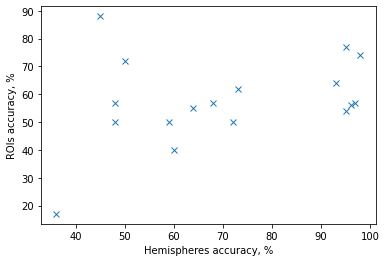

In [7]:
rois = [50, 77, 74, 72, 50, 57, 57, 62, 64, 54, 56, 17, 50, 88, 55, 57, 40,]# 39, 63, 41]
hemis = [59, 95, 98, 50, 48, 48, 97, 73, 93, 95, 96, 36, 72, 45, 64, 68, 60,]# 3, 71, 41]

# plt.plot(rois, hemis, 'x')
# plt.show()
plt.plot(hemis, rois, 'x')
plt.xlabel('Hemispheres accuracy, %')
plt.ylabel('ROIs accuracy, %')
plt.show()

In [5]:
print(sp.stats.spearmanr(rois, hemis))
print(sp.stats.pearsonr(rois, hemis))


SpearmanrResult(correlation=0.29839908228635526, pvalue=0.2446825909683375)
(0.31864598766929964, 0.21256350182108505)
